#Association between country GHG emissions and climate-related deaths

 During COP 29, The African Development Bank Group stated that 'Although Africa contributes less than 4% of global greenhouse gas emissions, it bears a disproportionate load of the climate crisis.'

 I found one interesting way to investigate this claim is to compare per capita Green House Gas (GHG) emissions per country against reported climate-related deaths.   

Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import requests
import json

In [2]:
plt.style.use('ggplot')

## 1. Loading the datasets



In [3]:
#dataset matching countries with their regions and sub-regions
country_dataset=pd.read_csv('https://datahub.io/core/country-codes/_r/-/data/country-codes.csv')
country_continents=country_dataset[['ISO3166-1-Alpha-3','official_name_en','Region Name','Sub-region Name']]
country_continents.columns=['Country Code','Country','Continent','Sub-continent']
country_continents.head()

,Country Code,Country,Continent,Sub-continent
0,AFG,Afghanistan,Asia,Southern Asia
1,ALA,Åland Islands,Europe,Northern Europe
2,ALB,Albania,Europe,Southern Europe
3,DZA,Algeria,Africa,Northern Africa
4,ASM,American Samoa,Oceania,Polynesia


###GHG emissions dataset (source: EU EDGAR)

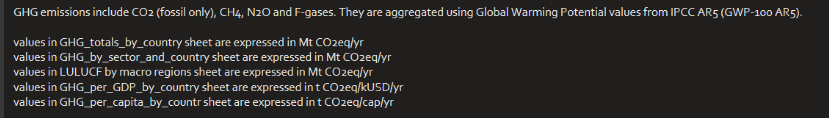

In [4]:
#download link from EDGAR website
url1='https://edgar.jrc.ec.europa.eu/booklet/EDGAR_2024_GHG_booklet_2024.xlsx'
global_xl=pd.ExcelFile(url1)
#import the sheets to a separate dfs
country_GHG=global_xl.parse('GHG_totals_by_country')
sector_GHG=global_xl.parse('GHG_by_sector_and_country')
GHG_per_GDP=global_xl.parse('GHG_per_GDP_by_country')
GHG_per_capita=global_xl.parse('GHG_per_capita_by_country')

###GDP per capita dataset (source:World Bank)

In [5]:
url2='https://api.worldbank.org/v2/en/indicator/NY.GDP.PCAP.CD?downloadformat=excel'
gdp_pc_xl=pd.ExcelFile(url2)
#gdp_pc_xl.sheet_names # output['Data', 'Metadata - Countries', 'Metadata - Indicators']

#retrieve the 'Data' tab
gdp_pc=gdp_pc_xl.parse('Data')

# delete unwanted rows
gdp_pc.drop(index=[0,1], inplace=True)

#set the column headers
gdp_pc.columns=gdp_pc.iloc[0]
gdp_pc.drop(index=2, inplace=True)
gdp_pc.rename(columns={'Country Name':'Country'}, inplace=True)

#reset the index
gdp_pc.reset_index(drop=True, inplace=True)

gdp_pc.head()

2,Country,Country Code,Indicator Name,Indicator Code,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,...,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,26129.839062,27458.225331,27441.529662,28440.051964,30082.127645,31096.205074,22855.932320,27200.061079,30559.533535,33984.790620
1,Africa Eastern and Southern,AFE,GDP per capita (current US$),NY.GDP.PCAP.CD,186.132432,186.947182,197.408105,225.447007,209.005786,226.883067,...,1656.107642,1479.564123,1329.777824,1520.171298,1538.924188,1493.780445,1344.080962,1522.590088,1628.024526,1659.515290
2,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,625.054942,565.569730,522.082216,525.469771,491.337221,496.602504,510.787063,356.496214,357.261153,415.707417
3,Africa Western and Central,AFW,GDP per capita (current US$),NY.GDP.PCAP.CD,121.938353,127.452629,133.825452,139.006714,148.547736,155.563837,...,2204.995700,1845.767804,1616.843198,1560.162999,1703.896392,1783.654365,1664.249176,1747.840549,1777.235012,1568.724310
4,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,5005.999741,3213.902611,1807.952941,2437.259712,2538.591391,2189.855714,1449.922867,1925.874661,2929.694455,2308.159767


###GNI per capita dataset ( source World Bank)

In [6]:
url3='https://api.worldbank.org/v2/en/indicator/NY.GNP.PCAP.CD?downloadformat=excel'
gni_pc_xl=pd.ExcelFile(url3)

#retrieve the 'Data' tab
gni_pc=gni_pc_xl.parse('Data')

# delete unwanted rows
gni_pc.drop(index=[0,1], inplace=True)

#set the column headers
gni_pc.columns=gni_pc.iloc[0]
gni_pc.drop(index=2, inplace=True)
gni_pc.rename(columns={'Country Name':'Country'}, inplace=True)

#reset the index
gni_pc.reset_index(drop=True, inplace=True)

gni_pc.head()

2,Country,Country Code,Indicator Name,Indicator Code,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,...,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
0,Aruba,ABW,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,24750.000000,24460.000000,25270.000000,27110.000000,28130.000000,28720.000000,22220.000000,28020.000000,30590.000000,30120.000000
1,Africa Eastern and Southern,AFE,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,189.385293,202.994308,204.818607,217.184561,...,1632.594795,1520.193335,1388.377418,1360.729674,1426.994115,1489.693436,1381.202876,1451.609900,1534.027144,1579.924932
2,Afghanistan,AFG,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,640.000000,590.000000,560.000000,530.000000,520.000000,520.000000,490.000000,380.000000,370.000000,380.000000
3,Africa Western and Central,AFW,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2061.135849,1972.431208,1750.339272,1570.400788,1598.675892,1671.338955,1674.520056,1729.821959,1771.570654,1680.838434
4,Angola,AGO,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4800.000000,3920.000000,2540.000000,2090.000000,1970.000000,2110.000000,1680.000000,1640.000000,1870.000000,2120.000000


###Climate-related deaths dataset (source: Our World in Data)

Death rates are measured per 100,000 people. Disasters include all geophysical, meteorological and
climate events including earthquakes, volcanic activity, landslides, drought, wildfires, storms, and
flooding

In [7]:
deaths_data=pd.read_csv('death-rate-from-disasters.csv') # file downloaded from 'Our World in Data' website
deaths_data.columns=['Country', 'Year', 'Death rates from disaster']
death_rates=deaths_data.pivot(index='Country', columns='Year', values='Death rates from disaster')
death_rates.fillna(0,inplace=True)
death_rates.reset_index(inplace=True)
death_rates.head()

Year,Country,1900,1901,1902,1903,1904,1905,1906,1907,1908,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Afghanistan,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,1.321344,0.242521,0.634058,0.308013,0.558652,0.841625,0.987545,3.245903,6.349453,0.244392
1,Africa,7.927802,0.0,0.0,0.012143,0.0,0.000000,0.0,0.0,0.0,...,0.108067,0.084814,0.159499,0.079057,0.204941,0.100391,0.039966,0.353534,1.462052,0.008829
2,Albania,0.000000,0.0,0.0,0.000000,0.0,14.226201,0.0,0.0,0.0,...,0.034692,0.069419,0.243110,0.000000,1.774603,0.000000,0.000000,12.384258,0.000000,0.000000
3,Algeria,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.030347,0.000000,0.000000,0.014311,0.018733,0.000000,0.233148,0.097989,0.092092,0.000000
4,American Samoa,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


##2. Data exploration

### Total emissions by region

In [8]:
country_GHG.rename(columns={'EDGAR Country Code':'Country Code'}, inplace=True)
country_GHG.head()

,Country Code,Country,1970,1971,1972,1973,1974,1975,1976,1977,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,ABW,Aruba,0.036713,0.041538,0.052391,0.057360,0.056630,0.070743,0.069793,0.080624,...,0.469468,0.490990,0.514539,0.496141,0.495532,0.588998,0.482160,0.531202,0.533603,0.561498
1,AFG,Afghanistan,15.437430,15.364077,13.316628,13.934875,15.177862,15.843058,15.943325,16.088215,...,27.420132,27.408332,26.633999,27.691927,27.553282,26.982777,26.646320,27.643074,28.614071,29.460052
2,AGO,Angola,18.998763,18.866057,21.459002,23.018941,23.685423,22.519608,18.586243,23.251029,...,77.295699,81.775031,78.875889,73.424409,69.504638,69.910832,61.680081,64.408994,67.210842,67.700756
3,AIA,Anguilla,0.003355,0.003396,0.003534,0.003411,0.003694,0.003968,0.003833,0.003960,...,0.031210,0.031334,0.031728,0.032476,0.031594,0.030948,0.026037,0.025224,0.025068,0.026211
4,AIR,International Aviation,172.478021,172.465452,182.459819,190.296910,183.162104,177.165836,177.483077,193.593366,...,514.263976,543.354255,567.631287,597.771580,624.135612,633.464502,302.632337,335.728729,416.953422,498.178114


In [9]:
#add a continent column
continent_GHG=pd.merge(country_GHG,country_continents[['Country Code', 'Continent']], on='Country Code', how='inner').groupby('Continent').sum().drop(columns=['Country','Country Code']).transpose()
#calculate emissions as a percentage of total for each continent
continent_GHG['Total']=continent_GHG.sum(axis=1)
continent_GHG.head()
continent_GHG_perc=continent_GHG.div(continent_GHG.Total, axis=0).drop(columns=['Total'])
continent_GHG_perc.tail()


Continent,Africa,Americas,Asia,Europe,Oceania
2019,0.063768,0.208872,0.569316,0.143549,0.014495
2020,0.063164,0.199219,0.584090,0.139155,0.014373
2021,0.062711,0.200681,0.582729,0.140229,0.013650
2022,0.062623,0.201897,0.584746,0.137393,0.013340
2023,0.061927,0.197716,0.596857,0.130311,0.013190


3177.9695527882222

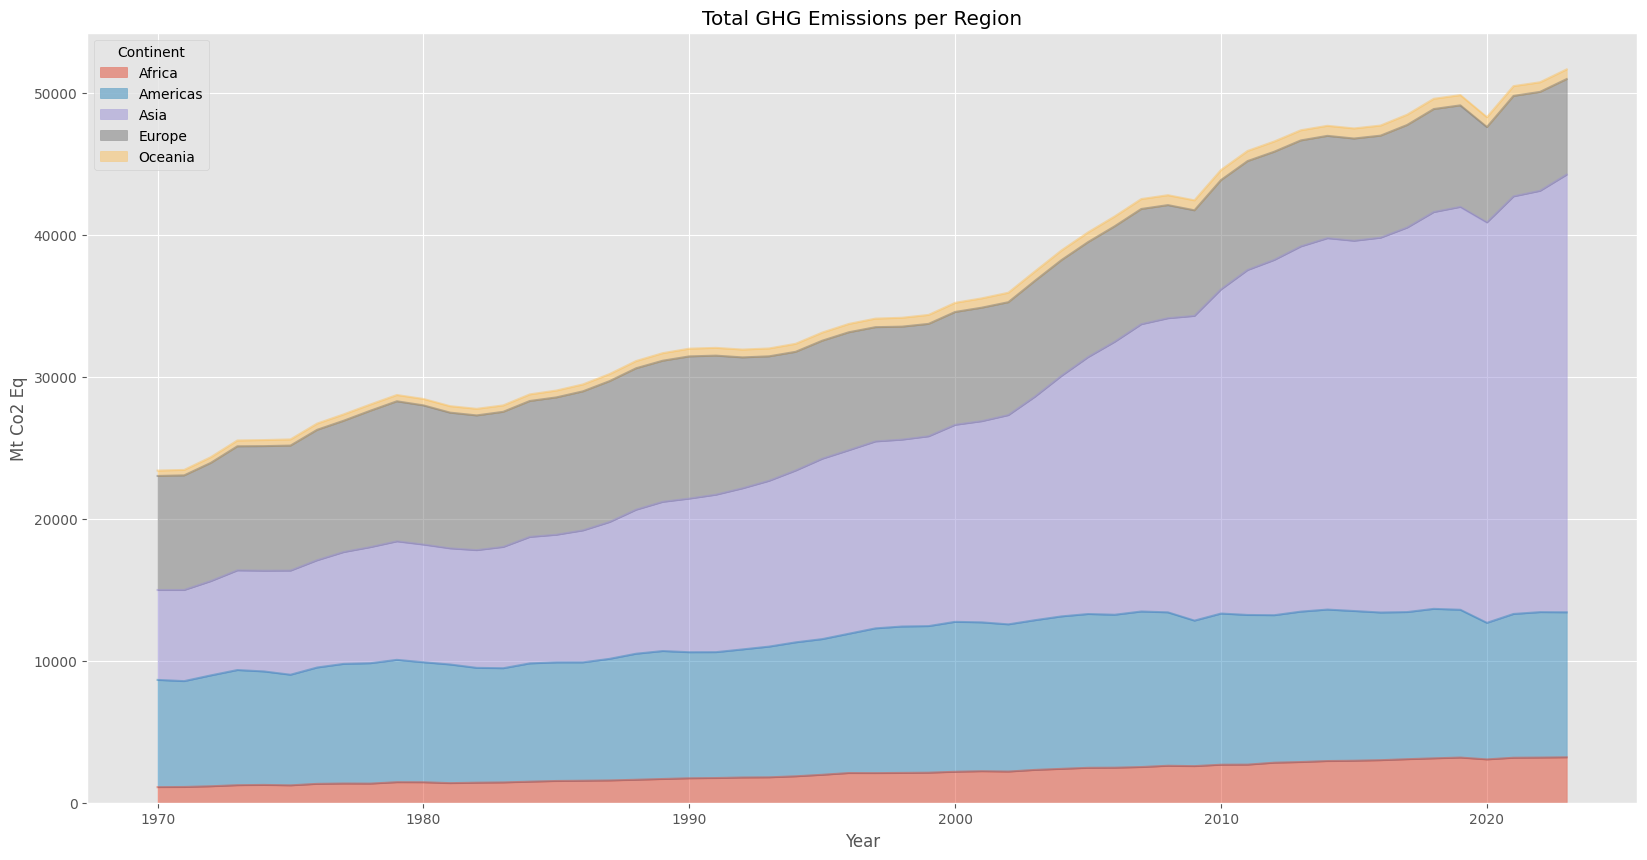

In [39]:
#visualization
continent_GHG.drop(columns=['Total']).plot(kind='area', alpha=0.5,figsize=(20, 10) )
plt.title('Total GHG Emissions per Region')
plt.ylabel('Mt Co2 Eq')
plt.xlabel('Year')

popup_years=[1970,1980,1990,2000,2010,2020,2023]
popup_continents=['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']
for popup_year in popup_years:
  for popup_continent in popup_continents:
    plt.annotate(str(continent_GHG_perc.loc[popup_year][popup_continent]), xy=(popup_year,continent_GHG.loc[popup_year][popup_continent]))


plt.show()

### Emissions vs. economic output

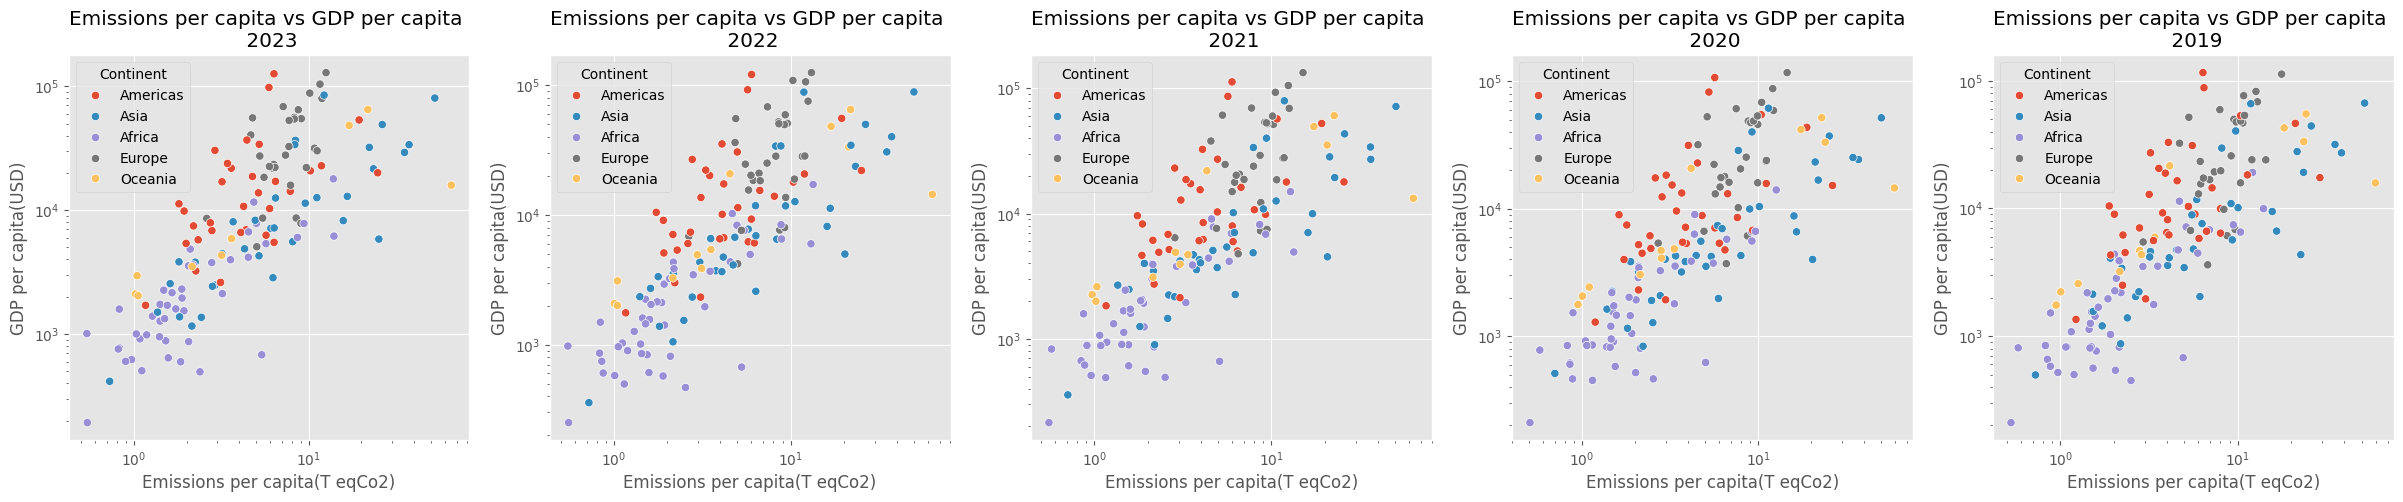

In [128]:
#trend over the last 5 years

fig, axes = plt.subplots(1, 5, figsize=(30, 5))
for year in range(2019,2024):
  df=pd.merge(pd.merge(GHG_per_capita[['Country', year]], gdp_pc[['Country',year]], on='Country', how='inner'),country_continents[['Country', 'Continent']], on='Country', how='inner').dropna()
  df.columns=['Country','Emissions per capita(T eqCo2)','GDP per capita(USD)','Continent']
  sns.scatterplot(ax=axes[2023-year],data=df,x='Emissions per capita(T eqCo2)',y='GDP per capita(USD)', hue='Continent')
  axes[2023-year].set(title=f'Emissions per capita vs GDP per capita \n {year}')
  axes[2023-year].set_xscale('log')
  axes[2023-year].set_yscale('log')



###Emissions vs. income

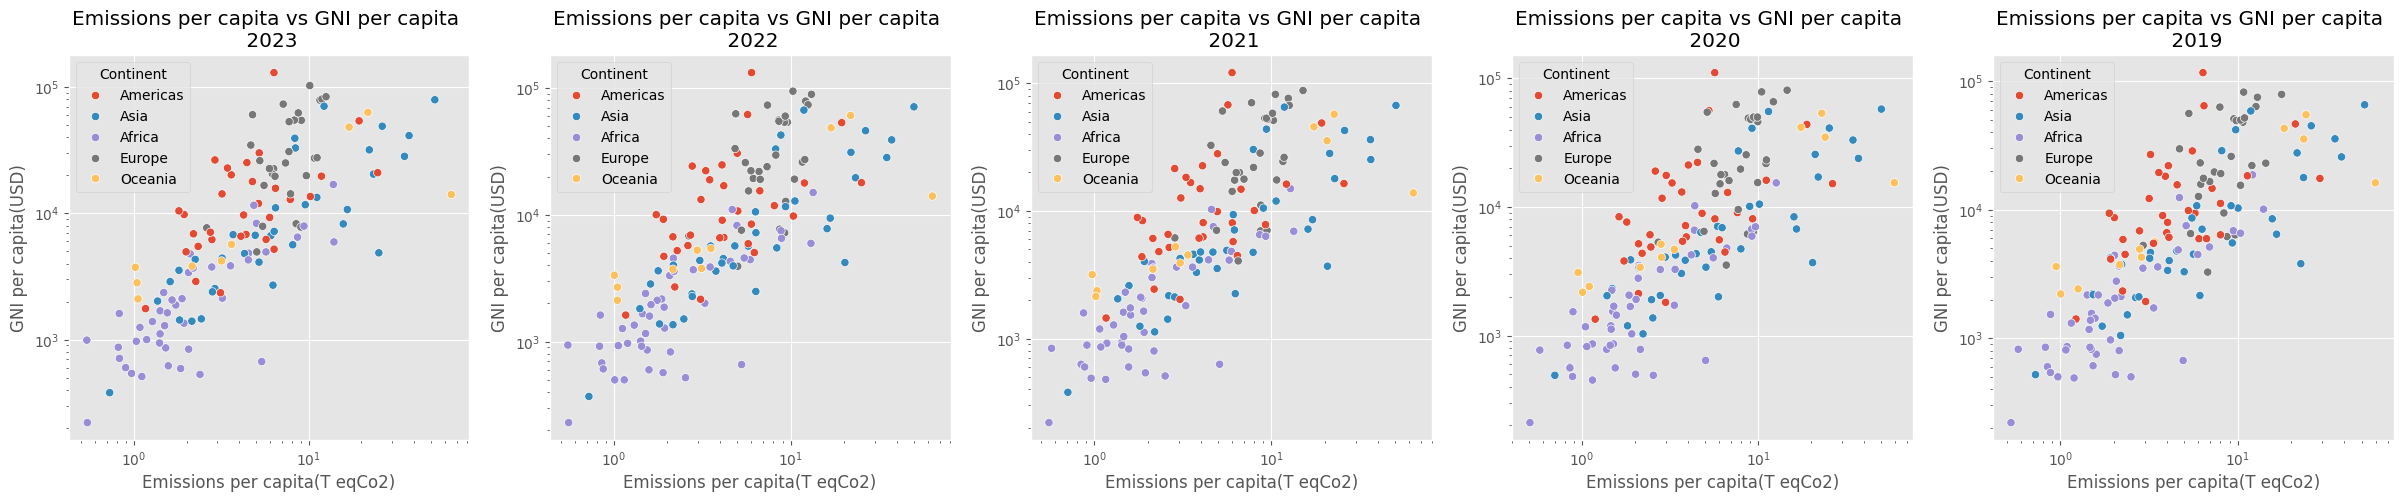

In [127]:
#trend over the last 5 years
fig, axes = plt.subplots(1, 5, figsize=(30, 5))
for year in range(2019,2024):
  df=pd.merge(pd.merge(GHG_per_capita[['Country', year]], gni_pc[['Country',year]], on='Country', how='inner'),country_continents[['Country', 'Continent']], on='Country', how='inner').dropna()
  df.columns=['Country','Emissions per capita(T eqCo2)','GNI per capita(USD)','Continent']
  sns.scatterplot(ax=axes[2023-year],data=df,x='Emissions per capita(T eqCo2)',y='GNI per capita(USD)', hue='Continent')
  axes[2023-year].set(title=f'Emissions per capita vs GNI per capita \n {year}')
  axes[2023-year].set_xscale('log')
  axes[2023-year].set_yscale('log')

### Emissions vs. climate-related deaths


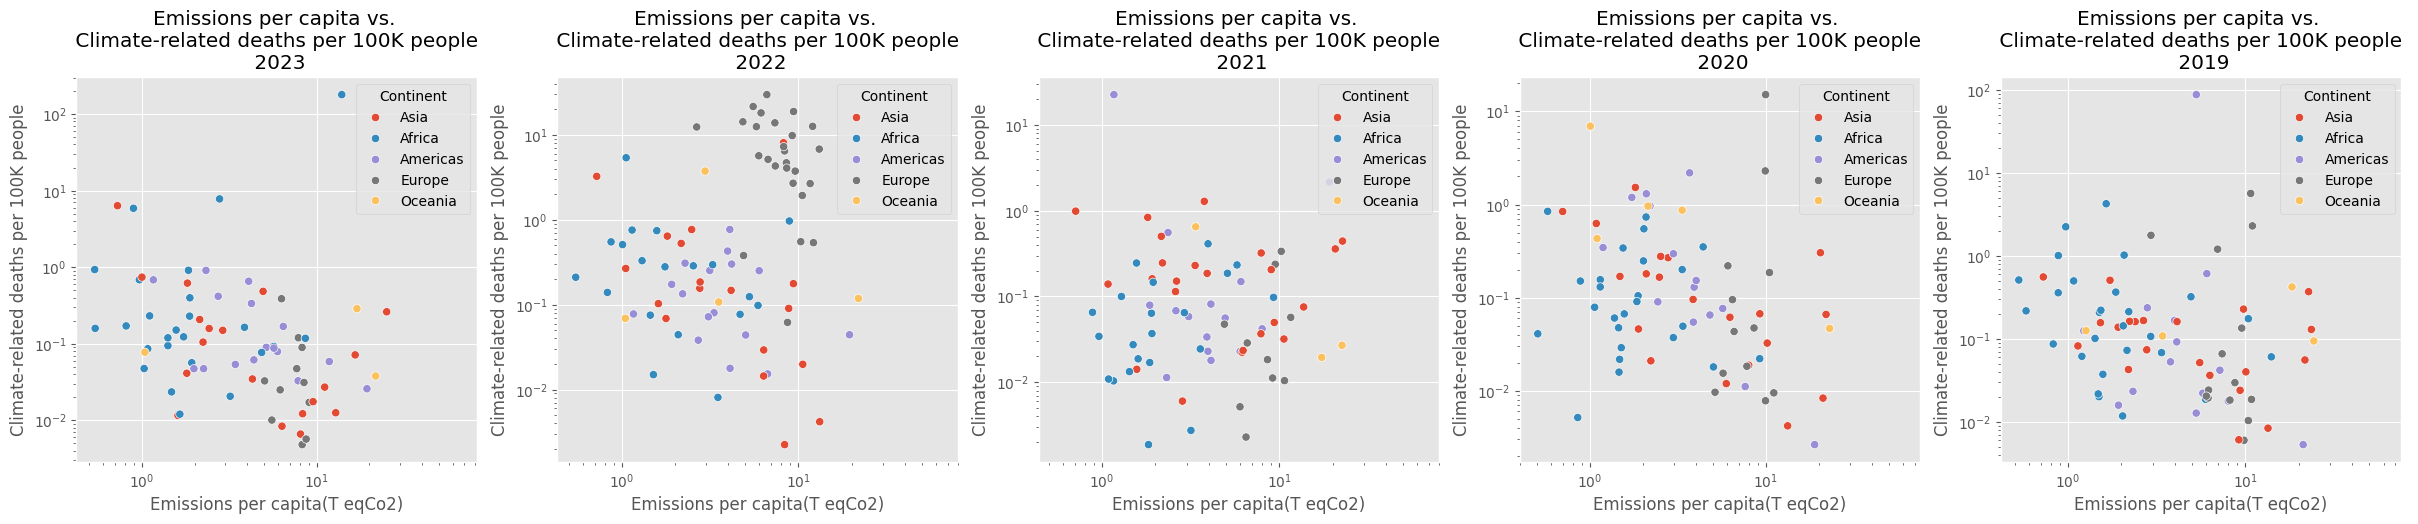

In [126]:
fig, axes = plt.subplots(1, 5, figsize=(30, 5))
for year in range(2019,2024):
  df=pd.merge(pd.merge(GHG_per_capita[['Country', year]], death_rates[['Country',year]], on='Country', how='inner'),country_continents[['Country', 'Continent']], on='Country', how='inner').dropna()
  df.columns=['Country','Emissions per capita(T eqCo2)','Climate-related deaths per 100K people','Continent']
  sns.scatterplot(ax=axes[2023-year],data=df,x='Emissions per capita(T eqCo2)',y='Climate-related deaths per 100K people', hue='Continent')
  axes[2023-year].set(title=f'Emissions per capita vs. \n Climate-related deaths per 100K people \n {year}')
  axes[2023-year].set_xscale('log')
  axes[2023-year].set_yscale('log')

###Historical correlation

In [96]:
gni_emiss_corr=pd.DataFrame(columns=['Year','Correlation(emissions per capita and GNI per capita)'])
for year in range(1980,2024):
  df=pd.merge(GHG_per_capita[['Country',year]], gni_pc[['Country',year]], on='Country', how='inner')
  df.columns=['Country','Emissions_pc','GNI_pc']

  #drop rows with empty values
  df.dropna()
  Corr=df.corr(method='kendall', numeric_only=True).iloc[1,0]
  gni_emiss_corr.loc[len(gni_emiss_corr.index)]=[year,Corr]

In [97]:
gdp_emiss_corr=pd.DataFrame(columns=['Year','Correlation(emissions per capita and GDP per capita)'])
for year in range(1980,2024):
  df=pd.merge(GHG_per_capita[['Country',year]], gdp_pc[['Country',year]], on='Country', how='inner')
  df.columns=['Country','Emissions_pc','GDP_pc']

  #drop rows with empty values
  df.dropna()
  Corr=df.corr(method='kendall', numeric_only=True).iloc[1,0]
  gdp_emiss_corr.loc[len(gdp_emiss_corr.index)]=[year,Corr]

In [98]:
death_emiss_corr=pd.DataFrame(columns=['Year','Correlation(emissions per capita and climate related death rates)'])
for year in range(1980,2024):
  df=pd.merge(GHG_per_capita[['Country',year]], death_rates[['Country',year]], on='Country', how='inner')
  df.columns=['Country','Emissions_pc','deaths_p100K']

  #drop rows with empty values
  df.dropna()
  Corr=df.corr(method='kendall', numeric_only=True).iloc[1,0]
  death_emiss_corr.loc[len(death_emiss_corr.index)]=[year,Corr]

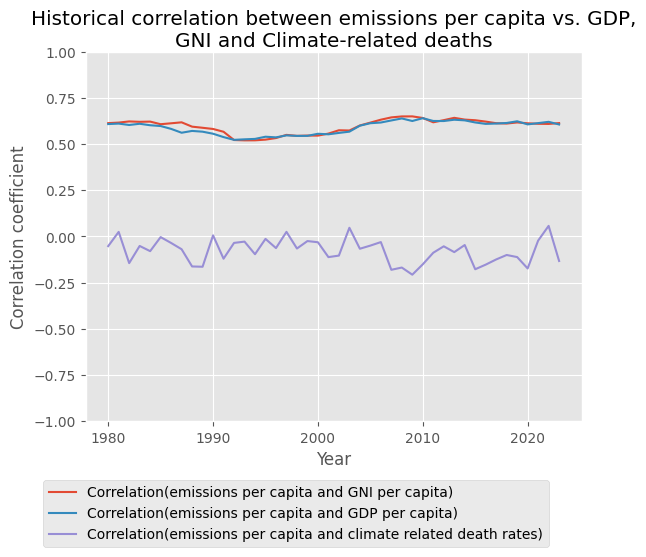

In [112]:
pd.merge(pd.merge(gni_emiss_corr, gdp_emiss_corr, on='Year', how='inner'),death_emiss_corr, on='Year', how='inner').plot(kind='line',x='Year',y=['Correlation(emissions per capita and GNI per capita)','Correlation(emissions per capita and GDP per capita)','Correlation(emissions per capita and climate related death rates)'])
plt.ylim(-1,1)
plt.ylabel('Correlation coefficient')
plt.xlabel('Year')
plt.title('Historical correlation between emissions per capita vs. GDP, GNI and Climate-related deaths', wrap=True)
plt.legend(loc='center left', bbox_to_anchor=(-0.1, -0.25))
plt.show()

##Data sources:

**GHG emissions data:**

EDGAR (Emissions Database for Global Atmospheric Research) Community GHG Database, a collaboration between the European Commission, Joint Research Centre (JRC), the International Energy Agency (IEA), and comprising IEA-EDGAR CO2, EDGAR CH4, EDGAR N2O, EDGAR F-GASES version EDGAR_2024_GHG (2024) European Commission, JRC (Datasets). The complete citation of the EDGAR Community GHG Database is available in the 'Sources and References' section.

IEA-EDGAR CO2, a component of the EDGAR (Emissions Database for Global Atmospheric Research) Community GHG database version EDGAR_2024_GHG (2024) including or based on data from IEA (2023) Greenhouse Gas Emissions from Energy, www.iea.org/data-and-statistics, as modified by the Joint Research Centre.

See 2024 report (https://edgar.jrc.ec.europa.eu/report_2024)


**Climate-realted disasters:**

International Monetary Fund. 2022.Climate Change Indicators Dashboard. Climate-related Disasters Frequency, https://climatedata.imf.org/pages/access-data. Accessed on 2025/01/12.

**GNI/GDP per capita:**

World Bank national accounts data, and OECD National Accounts data files.

https://data.worldbank.org/indicator/NY.GNP.PCAP.CD

https://data.worldbank.org/indicator/NY.GDP.PCAP.CD

**Deaths from natural disasters:**

Our World in Data based on EM-DAT, CRED / UCLouvain, Brussels, Belgium – www.emdat.be (D. Guha-Sapir) – processed by Our World in Data